**6장 – 결정 트리**

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 6.1 결정 트리 학습과 시각화

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

**<그림 6-1. 붓꽃 결정 트리> 생성 코드**

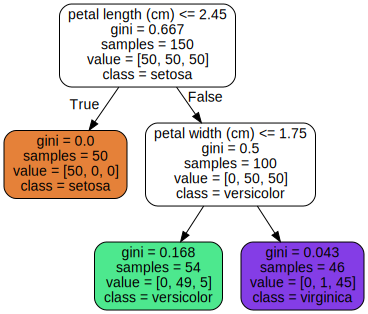

In [4]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

**트리 구조** 

---


뿌리(root)노드로 부터 노드들이 가지(branch)들로 노드가 연결되어 있고 마지막 노드들이 잎(leaf)처럼 달려있는 자료구조

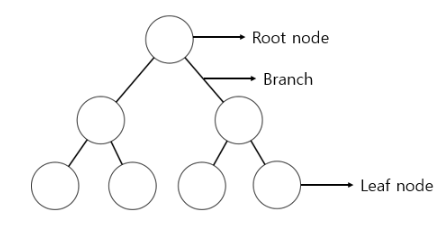

1) root node~leaf **node**전까지의 node: input데이터를 분류할 수 있는 특성(attribute,feature) 

2) **branch**: 그 feature가 가질 수 있는 값(value) ex)high,normal

3) **leaf node**: 분류결과(output)

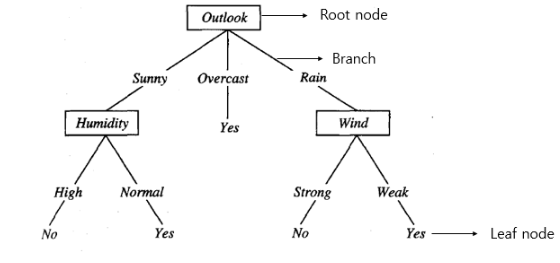

## **특성(attribute)을 어떤 순서로, 어떤 배치로 질문을 할지를 정하는 것이 decision tree의 핵심!**

# 6.2 예측하기



---





의사결정 나무: 탐욕 알고리즘 (greedy algorithm)


Root node에서 시작해서 아래로 내려가며 반복적으로 파티션을 나눈다.

한 번 분리가 되면 다시 되돌리지 않고 끝까지 간다!

결정 경계 (decision boundary)가 축에 평행하다.



---



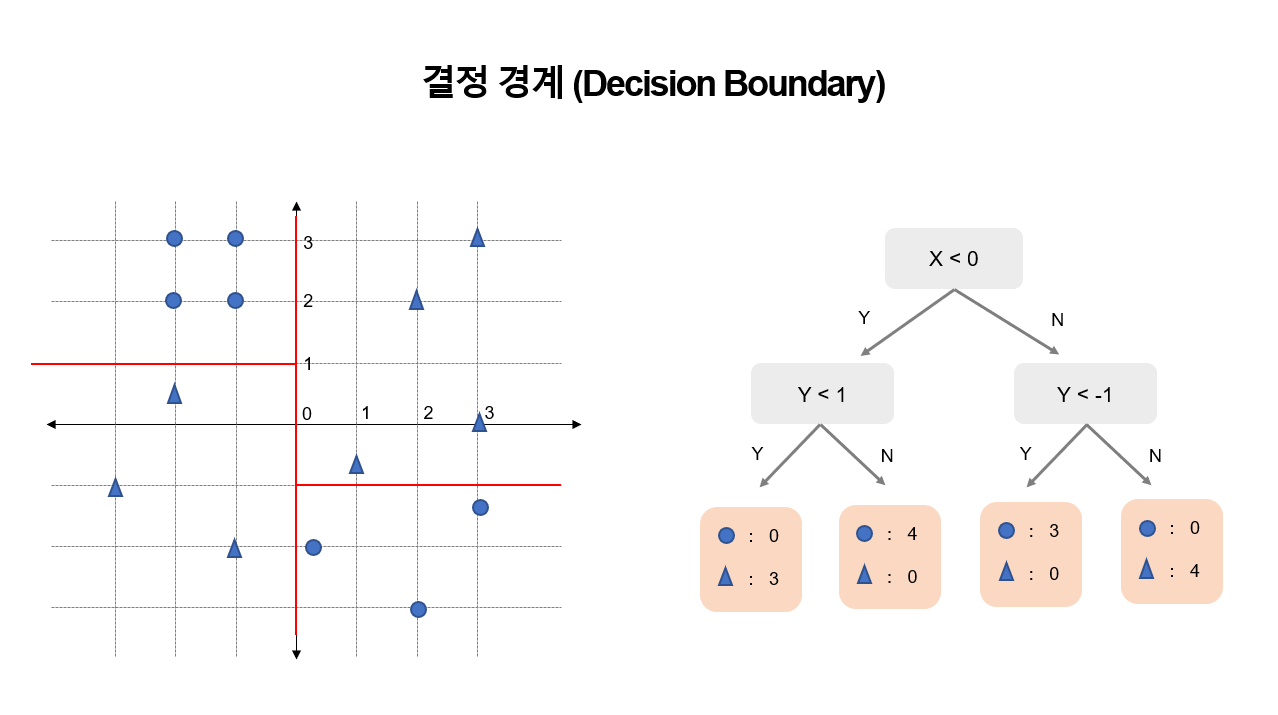

# 최적의 의사결정 나무는 어떻게 찾고, 무엇을 기준으로 평가할 수 있는가?

불순도 (Impurity)

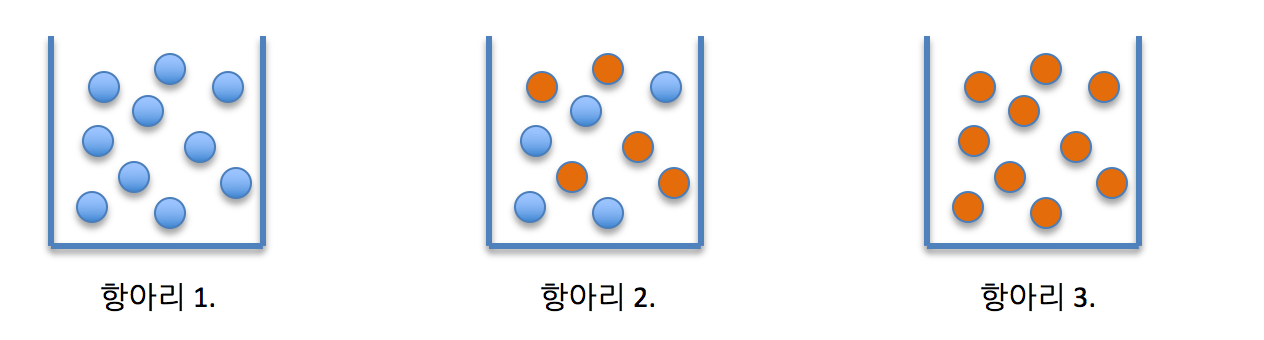

지니 불순도 (Gini Impurity): 집합의 "순도"를 측정

경제학에서, 지니계수(Gini index): 경제적 불평등을 표현하는 방법

지니계수가 1에 가까울수록 소수의 사람이 다 해먹는 것을 의미하고, 0에 가까울수록 모두가 평등함을 의미

따라서, 지니계수가 0에 가까울수록 그 클래스에 속한 불순도가 낮으므로(한 노드의 데이터들이 같은 클래수로 분류되는 것이므로) 좋다!

불순도가 낮다 = 순도 증가 = entropy가 낮아진다.

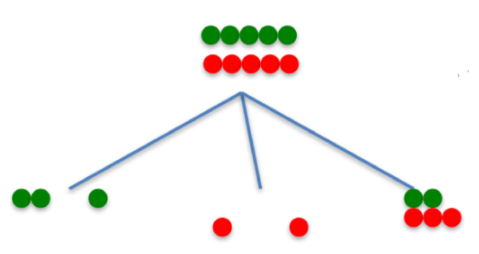

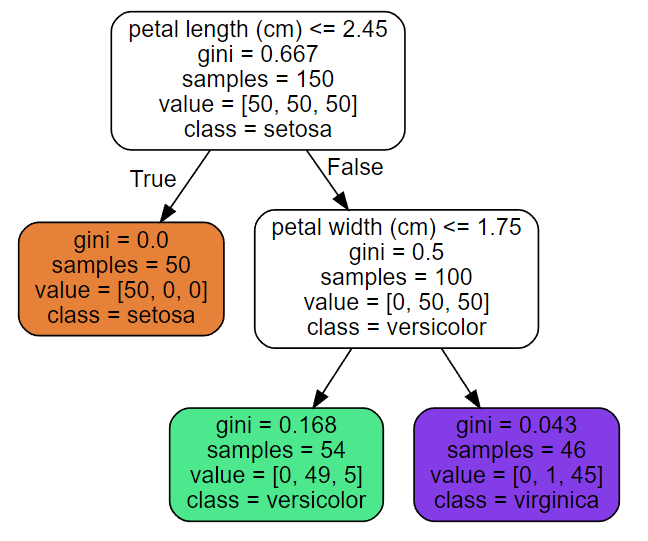

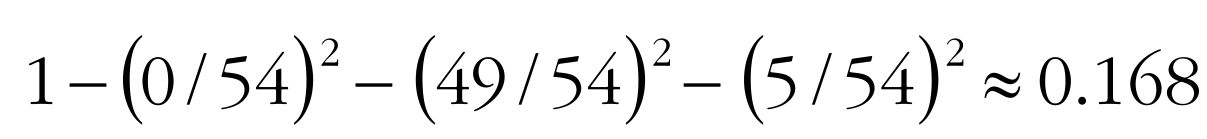

**식 6-1: 지니 불순도**

$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$

**식 6-3: 엔트로피 불순도**

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$


**식 6-2: 분류에 대한 CART 비용 함수**

$
\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\
&\text{여기에서 }\begin{cases}
G_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 불순도}\\
m_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 샘플 수}
\end{cases}
\end{split}
$

**<그림 6-2. 결정 트리의 결정 경계> 생성 코드**

그림 저장: decision_tree_decision_boundaries_plot


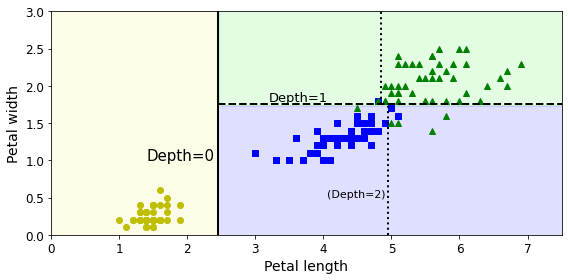

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

# 6.3 클래스 확률 추정

한 샘플이 특정 클래스 k에 속할 확률 추정 가능

leaf node를 찾기 위해 tree를 탐색하고, 해당 node에 있는 클래스 k의 training sample 비율 반환

In [6]:
# 길이가 5cm이고 너비가 1.5cm인 꽃잎
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

# 가장 높은 확률의 인덱스 값 반환하기

In [7]:
tree_clf.predict([[5, 1.5]])
# 가장 높은 확률을 가진 class 1이 출력됨

array([1])

# 6.4 CART 훈련 알고리즘

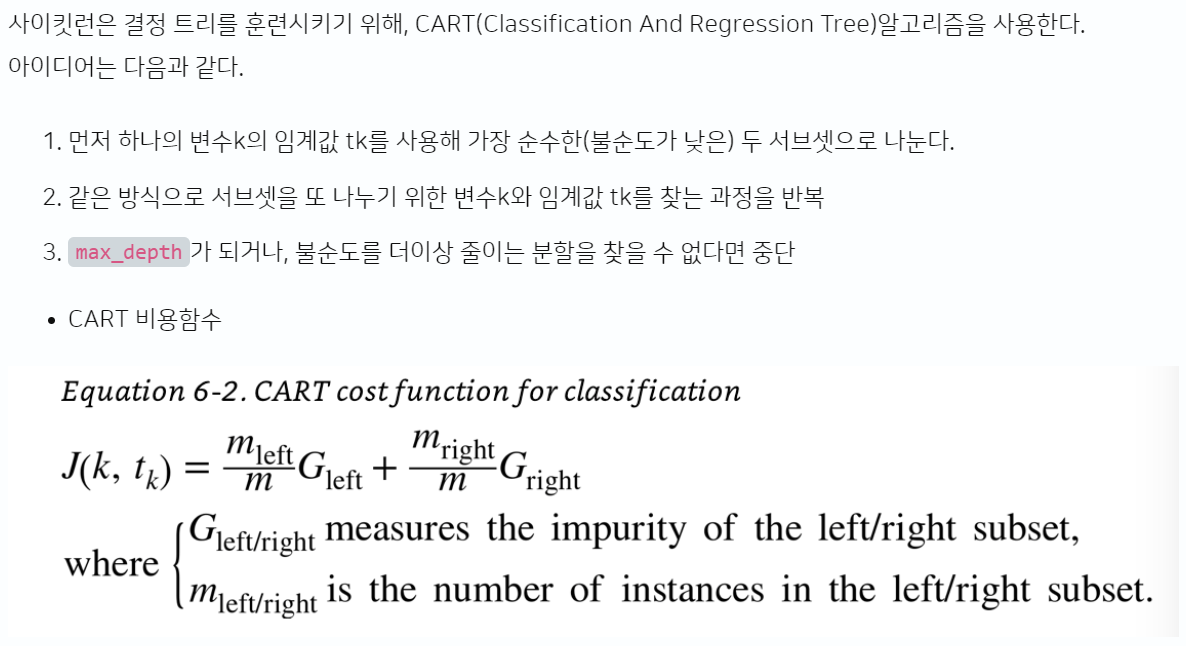

# 6.5 계산 복잡도

결정 트리를 탐색하기 위해서는 log2(m)개의 노드를 거쳐야한다.

# 6.7 규제 매개변수

Overfitting을 방지하기 위해, 결정트리의 자유도 제한 --> 규제 (Hyparameter)

*   max_depth : 최대 깊이

*   min_samples_split : 분할되기 위해 노드가 가져야 하는 최소 샘플 수

*   min_samples_leaf : 리프 노드가 가져야 하는 최소 샘플 수

*   min_weight_fraction_leaf : 피트 노드가 가져야 하는 전체 샘플 수에서의 비율

*   max_leaf_nodes : 리프 노드의 최대 수

*   max_features : 분할에 사용할 특성의 최대 수


**<그림 6-3. min_samples_leaf 매개변수를 사용한 규제> 생성 코드**

그림 저장: min_samples_leaf_plot


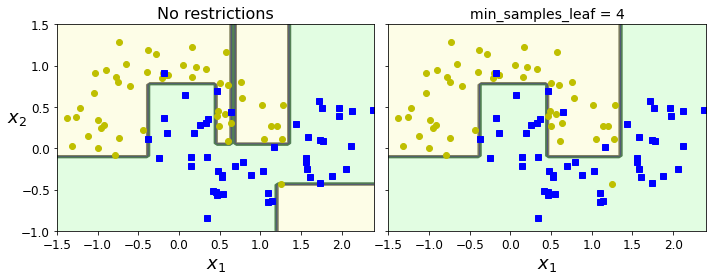

In [ ]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

# 6.8 회귀

간단한 선형 데이터셋을 준비합니다:

In [ ]:
# 2차함수 + noise 추가
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)              # 0~1사이 난수 생성 (200행 1열)
y = 4 * (X - 0.5) ** 2                # 임의의 2차 함수 생성
y = y + np.random.randn(m, 1) / 10    # noise 추가

**코드 예제:**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
export_graphviz(                                                      
        tree_reg1,                                                    # 모델
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),    # 저장경로 설정
        feature_names=["x1"],                                         # 변수명  
        rounded=True,                                                 # 시각화 (둥근네모)
        filled=True                                                   # 시각화 (도형 채우기) 
    )

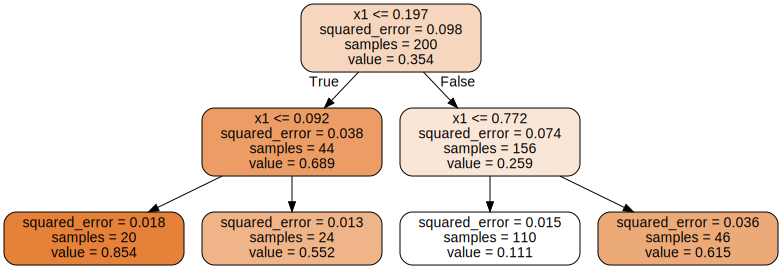

In [ ]:
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))    # 파일

**<그림 6-5. 두 개의 결정 트리 회귀 모델의 예측> 생성 코드**

**예측값과 가능한 한 많은 샘플이 가까이 있도록 영역 분할**

그림 저장: tree_regression_plot


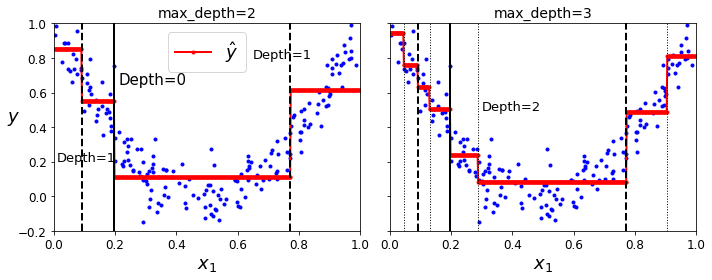

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

# 회귀에서의 분할 방식

--> **평균제곱오차 (MSE)를 최소화하도록 분할**

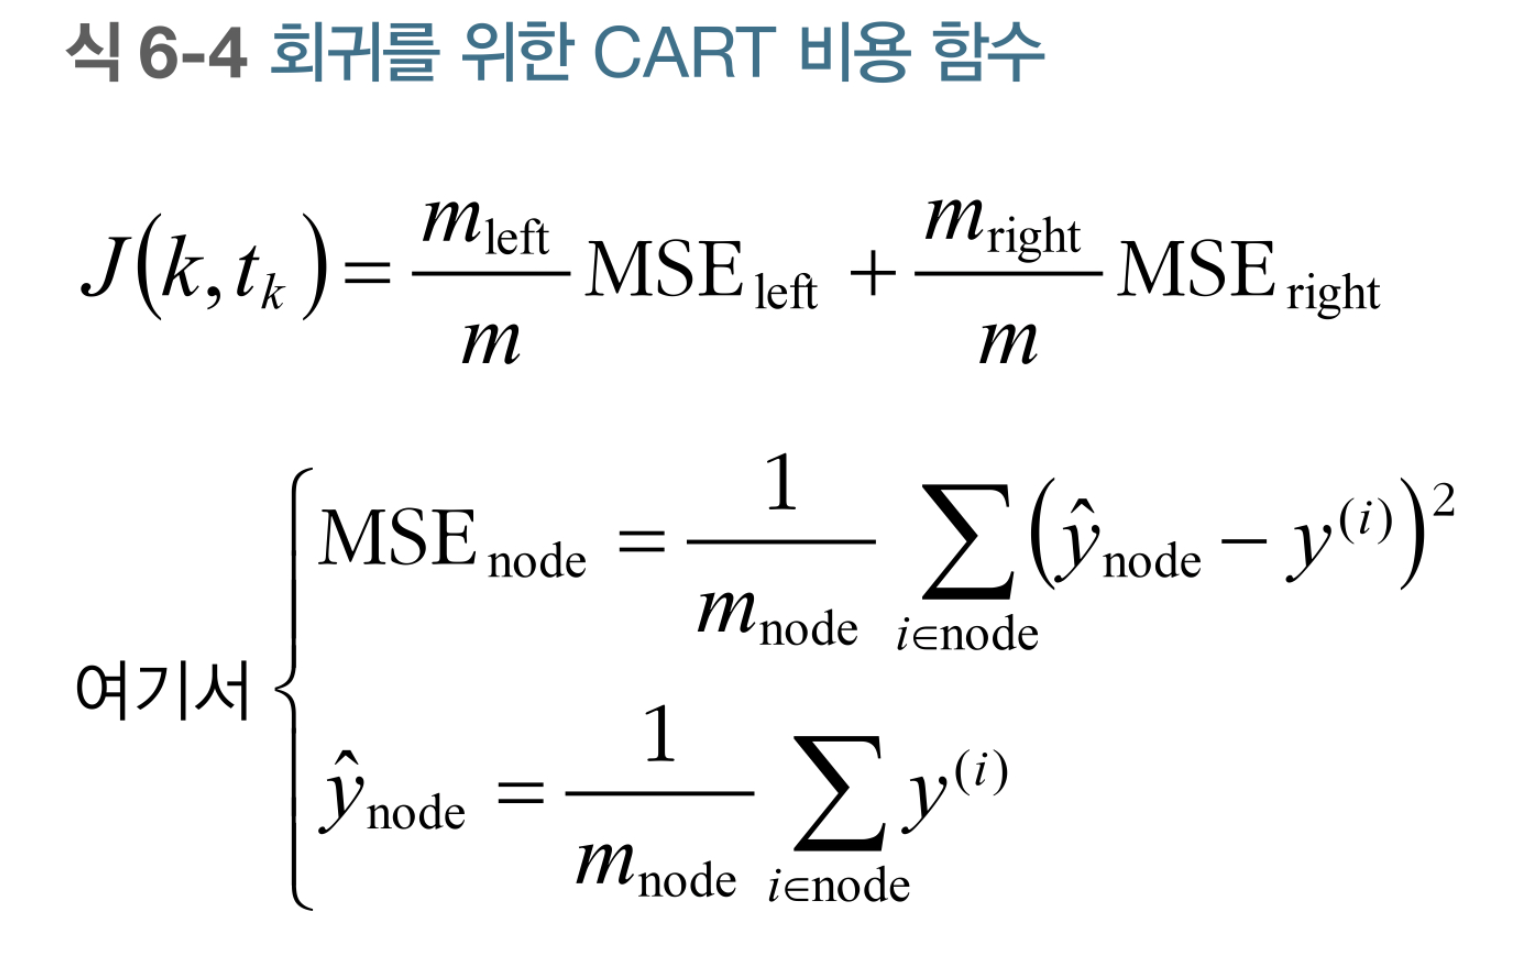

# 규제가 있는 것과 없는 것의 차이

그림 저장: tree_regression_regularization_plot


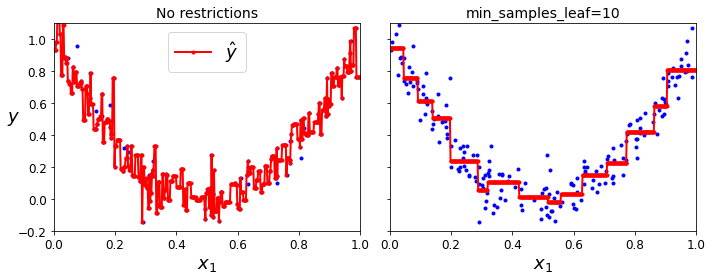

In [ ]:
tree_reg1 = DecisionTreeRegressor(random_state=42)                      # 규제 없는 모델
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10) # 규제 있는 모델
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

# 6.9 불안정성

결정트리: 계단 모양의 결정 경계를 만들어낸다. (모든 분할은 축에 수직)

--> Training set의 작은 변화에 굉장히 민감 (ex. training set 회전)

7장 랜덤포레스트에서는 많은 트리에서 만든 예측을 평균을 하는 방식으로 불안정성 극복!

**<그림 6-8. 훈련 세트의 세부사항에 민감한 결정 트리> 생성 코드**

그림 저장: decision_tree_instability_plot


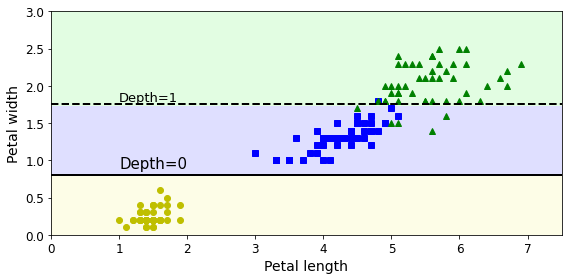

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

데이터셋을 회전하면 완전히 다른 결정 경계를 만듭니다:

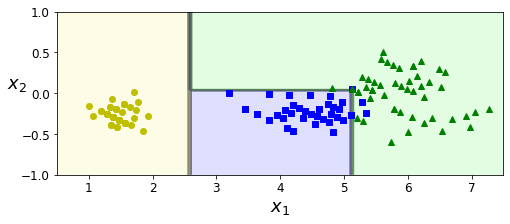

In [ ]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

**<그림 6-7. 훈련 세트의 회전에 민감한 결정 트리> 생성 코드**

그림 저장: sensitivity_to_rotation_plot


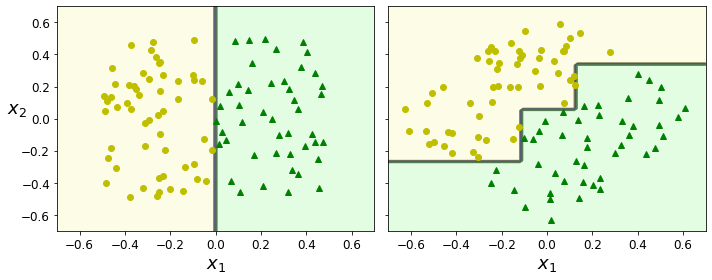

In [ ]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

## The End